In [142]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit

In [214]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [215]:
mapper = JordanWignerMapper()

In [216]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
aux_op = mapper.map(es_problem.second_q_ops()[1])
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-0.80718366 * IIII
+0.17374013 * IIIZ
-0.23047453 * IIZI
+0.12148839 * IIZZ
+0.17374013 * IZII
+0.16940471 * IZIZ
+0.16658220 * IZZI
+0.04509381 * XXXX
+0.04509381 * XXYY
+0.04509381 * YYXX
+0.04509381 * YYYY
-0.23047453 * ZIII
+0.16658220 * ZIIZ
+0.17510657 * ZIZI
+0.12148839 * ZZII


In [183]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [217]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(100e3, 20e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(150e3, 20e3, 4)  # Sampled from normal distribution mean 50 microsec

print(T1s, T2s)

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

print(T2s)

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

[ 95192.34455693 105677.98444079 115610.95687602  92873.04724861] [172973.25262863 164986.49936423 158363.08895793 159355.6653386 ]
[172973.25262863 164986.49936423 158363.08895793 159355.6653386 ]
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'measure', 'reset', 'u3']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


In [218]:
seed = 69

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": [(0, 1), (1, 2), (2, 3), (3, 4)],
        "noise_model": noise_thermal,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed}
)

In [219]:
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [270]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(noisy_estimator, ansatz, SPSA(), callback=store_intermediate_result)
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

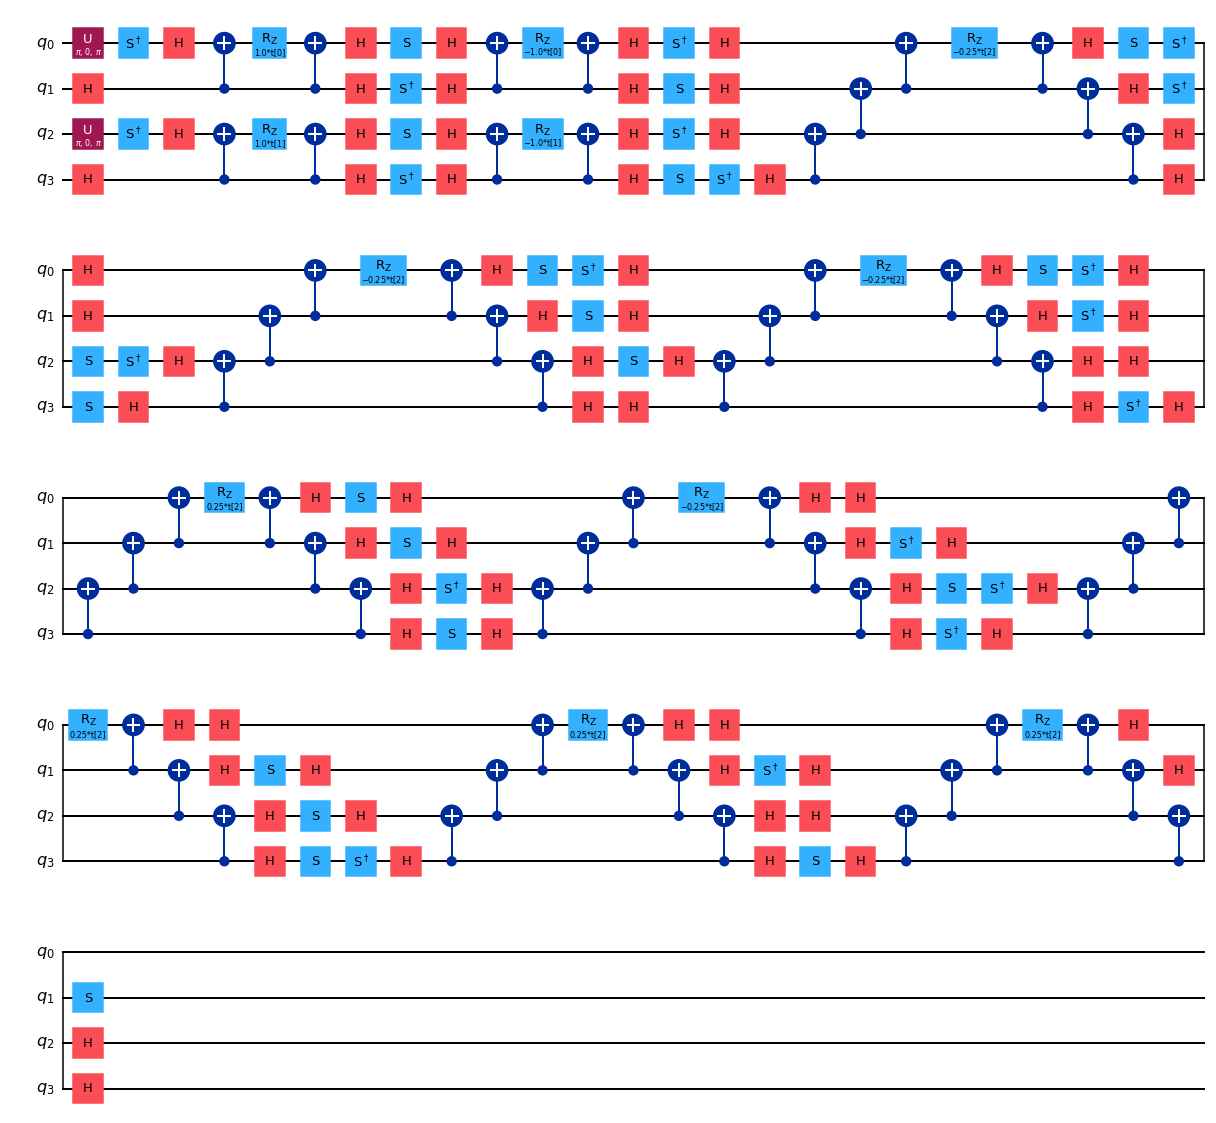

In [38]:
ansatz.decompose(reps=3).draw(output="mpl")

In [8]:
for excitation in ansatz._excitation_list:
    print(f"{excitation[0]} => {excitation[1]}")

(0,) => (1,)
(2,) => (3,)
(0, 2) => (1, 3)


In [221]:
raw_result = vqe_solver.compute_minimum_eigenvalue(qubit_op, aux_op)
res = es_problem.interpret(raw_result)
res.total_energies[0]

-0.9813575743045293

Text(0.5, 1.0, 'Convergence with noise')

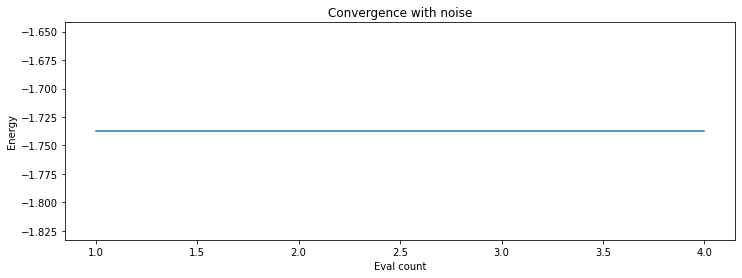

In [206]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with noise")

In [222]:
calculated = res.eigenvalues[0] + res._nuclear_repulsion_energy
actual = res._hartree_fock_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", res._hartree_fock_energy)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.2f}%")

Total Calculated Energy: -0.9813575743045293
Actual Energy: -1.117343269122583
Percentage Error: -13.86%


In [271]:
distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
vqe_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    qubit_op, aux_op = es_problem.second_q_ops()
    qubit_op, aux_op = mapper.map(qubit_op), mapper.map(aux_op)
    raw_result = vqe_solver.compute_minimum_eigenvalue(qubit_op, aux_op)
    res = es_problem.interpret(raw_result)
    vqe_energies.append(res.total_energies[0])

Calculating energies: 100%|██████████| 37/37 [01:28<00:00,  2.38s/it]


In [272]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

interpolated_function = interp1d(distances, vqe_energies, kind='cubic')
result = minimize_scalar(interpolated_function, bounds=(distances.min(), distances.max()), method='bounded')

min_distance = result.x
min_energy = result.fun
print(f"The distance that minimizes the energy is: {min_distance} Å")
print(f"The minimum energy is: {min_energy} Hartree")
# -0.98 hartree minimum energy for noisy
# -1.11 for noiseless

The distance that minimizes the energy is: 1.0678614446799823 Å
The minimum energy is: -1.026236468174177 Hartree


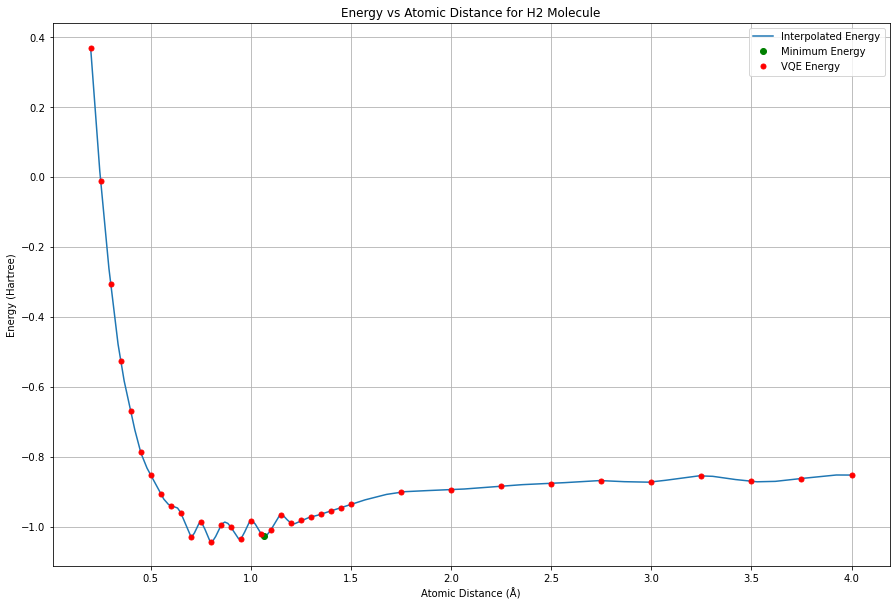

In [273]:
fine_distances = np.linspace(distances.min(), distances.max(), 500)
interpolated_energies = interpolated_function(fine_distances)
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(fine_distances, interpolated_energies, label='Interpolated Energy')
plt.plot(min_distance, min_energy, 'go', label='Minimum Energy')
plt.plot(distances, vqe_energies, marker='o', color='red', linestyle='', markersize=5, label='VQE Energy')
plt.xlabel('Atomic Distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy vs Atomic Distance for H2 Molecule')
plt.grid(True)
plt.legend()
plt.show()

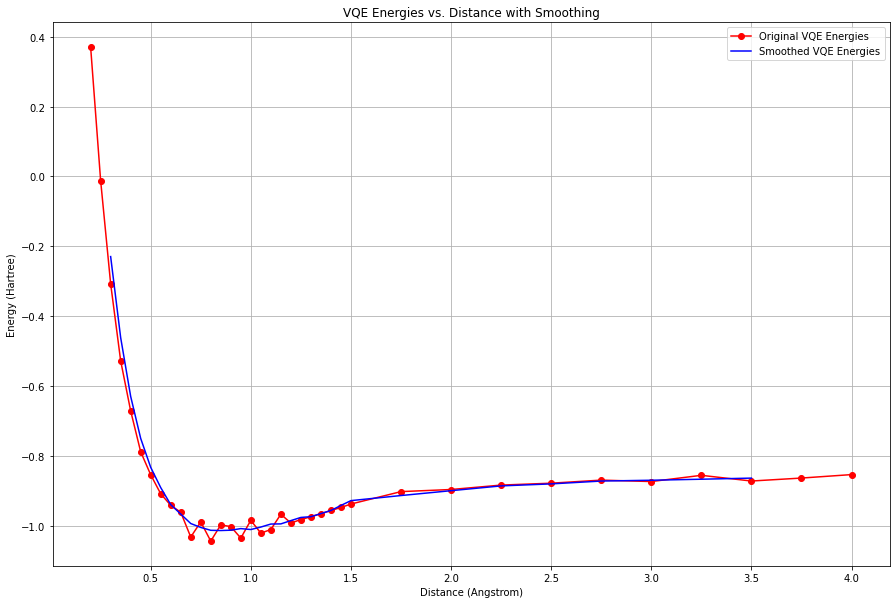

The minimum energy is -1.012664 Hartree at a distance of 0.850000 Angstrom


In [310]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size

# Apply convolution to smooth the energies
smoothed_energies = np.convolve(vqe_energies, kernel, mode='valid')

# Adjust distances to match the length of the smoothed energies
adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[(kernel_size)//2:-(kernel_size)//2]

# Plot the original and smoothed energies
plt.figure(figsize=(15, 10))
plt.plot(distances, vqe_energies, 'o-', label='Original VQE Energies', color='red')
plt.plot(adjusted_distances, smoothed_energies, '-', label='Smoothed VQE Energies', color='blue')

plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energies vs. Distance with Smoothing')
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {smoothed_energies.min():.6f} Hartree at a distance of {adjusted_distances[smoothed_energies.argmin()]:.6f} Angstrom")

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


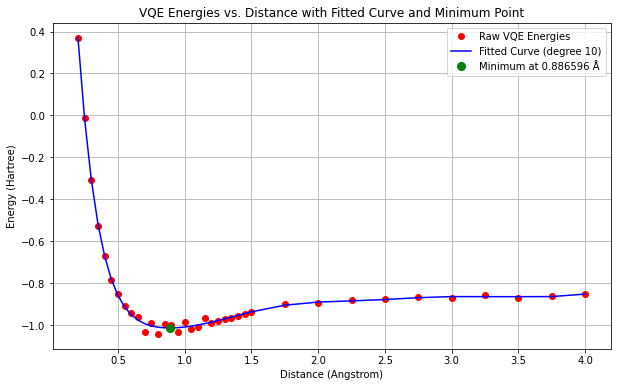

The minimum energy is -1.014147 Hartree at a distance of 0.886596 Angstrom


In [309]:
degree = 10  # Degree of the polynomial
coefficients = np.polyfit(distances, vqe_energies, degree)
fitted_curve = np.polyval(coefficients, distances)

critical_points = list(filter(lambda x: not np.iscomplex(x) and np.min(distances) <= x <= np.max(distances),
                              np.roots(np.polyder(coefficients))))
min_distance = critical_points[np.argmin(np.polyval(coefficients, critical_points))]
min_energy = np.polyval(coefficients, min_distance)

# Plot the raw data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(distances, vqe_energies, 'o', label='Raw VQE Energies', color='red')
plt.plot(distances, fitted_curve, '-', label=f'Fitted Curve (degree {degree})', color='blue')
plt.plot(min_distance, min_energy, 'go', label=f'Minimum at {min_distance.real:.6f} Å', markersize=8)

plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energies vs. Distance with Fitted Curve and Minimum Point')
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {min_energy.real:.6f} Hartree at a distance of {min_distance.real:.6f} Angstrom")